In [11]:
'''
from google.colab import drive
drive.mount('/content/gdrive')'''

Mounted at /content/gdrive


In [12]:
'''
import os
path="/content/gdrive/My Drive"
os.chdir(path)
os.listdir(path)'''

['net_config (6).cpython-37.pyc',
 '.ipynb_checkpoints',
 'net_config (5).cpython-37.pyc',
 'EnsembleModel (1).cpython-37.pyc',
 'net_config (4).cpython-37.pyc',
 'EnsembleModel.cpython-37.pyc',
 'net_config (3).cpython-37.pyc',
 'seqGAN',
 'ML_dialogue',
 'seqGAN_tran.ipynb',
 '6000J',
 '5002',
 '5012',
 'exam5003',
 'net_config (2).cpython-37.pyc',
 'MultiLabelTextClassification',
 'net_config (1).cpython-37.pyc',
 'net_config.cpython-37.pyc',
 'MAAL.ipynb',
 '5002final',
 'MSBD5002_Fall2021_Final_Data',
 'processed_text.csv']

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import preprocessing
import datetime
from dateutil.parser import parse 
import pytz 
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score ,roc_curve, auc, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import csv
import nltk
nltk.download('stopwords')
import pickle
from torch import multiprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.models import Word2Vec
import re
import seaborn as sns


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
train = pd.read_excel('/content/gdrive/My Drive/5002/final/Q6/train.csv.xlsx')
test = pd.read_excel('/content/gdrive/My Drive/5002/final/Q6/test.csv.xlsx')

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [24]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [22]:
#average length of sentence in test
test_text = test['text'].values
print(np.mean([len(i.split(' ')) for i in test_text]))

14.978853815507202


In [25]:
y = train['target']
print("Number of positive samples = %s" % sum(y==1))
print("Number of negative samples = %s" % sum(y==0))

Number of positive samples = 3271
Number of negative samples = 4342


In [13]:
def clean_txt(text):  
    text = re.sub(r'[^a-zA-Z]',' ',text)   
    text = text.lower()     
    stopwords = nltk.corpus.stopwords.words('english') 
    text = [s for s in text.replace("#", "").replace(",", "").replace(".", "").split(' ') if s != '']
    words_list = [w for w in text if w not in stopwords]
    return words_list


def get_index(sentence):
    sequence = []
    for word in sentence:
        try:
            sequence.append(word_dict[word])
        except KeyError:
            pass
    return sequence

def list_pad_2D(data, max_len, val):
    tmp = []
    for i in data:
        if (len(i) >= max_len):
            tmp.append(i[0:max_len])
        else:
            tmp.append(i + [val] * (max_len - len(i)))
    return np.array(tmp)


def struct_feat_process(data,feature_dim={}):
    data = data.fillna('nan')
    #transfer discrete feat
    count=len(feature_dim)
    for columnName, columnData in data.iteritems():
      u_feat = columnData.unique()
      for f in u_feat:
        if f not in feature_dim.keys():
          feature_dim[f] = count
          count+=1
    res=[]
    data = data.values
    for i in range(data.shape[0]):
      temp=[]
      for j in range(data.shape[1]):
        temp.append(feature_dim[data[i,j]])
      res.append(temp)
    return np.array(res),feature_dim



def prepocessing(aug=True):
    train = pd.read_excel('/content/gdrive/My Drive/5002/final/Q6/train.csv.xlsx')
    test = pd.read_excel('/content/gdrive/My Drive/5002/final/Q6/test.csv.xlsx')

    train_label = train['target']
    train_text = train['text'].values
    test_text = test['text'].values
    train.drop(['id','target','text'], axis=1, inplace=True)
    test.drop(['id','text'], axis=1, inplace=True)

    print('-------Deal with struct feature')
    feature_dim={}
    train_feat,feature_dim = struct_feat_process(train,feature_dim)
    test_feat,feature_dim = struct_feat_process(test,feature_dim)
    #print(train_feat)


    for i in range(train.shape[0]):
      train_text[i] = clean_txt(train_text[i])
    for i in range(test.shape[0]):
      test_text[i] = clean_txt(test_text[i])

    max_len = 20
    save_dim = 128

    print("-------Word2vec begin")

    model = Word2Vec(sentences=np.concatenate([train_text, test_text], axis=0), size=save_dim, window=10, min_count=3, workers=multiprocessing.cpu_count(), sg=1)

    model.save("5002final/wjy/w2v" + "_" + str(save_dim) + "_" + str(max_len) + '.model')
    
    global word_dict
    word_dict = {word: index+1 for index, word in enumerate(model.wv.vocab)}
    word_dict[' ']=0

    train_text = list_pad_2D(list(map(get_index, train_text)), max_len, 0)
    test_text = list_pad_2D(list(map(get_index, test_text)), max_len, 0)
    
    print('-------Finish Transfer, Saving')

    np.save("5002final/wjy/train_text_id_" + "_" + str(save_dim) + "_" + str(max_len), train_text)
    np.save("5002final/wjy/train_text_id_" + "_" + str(save_dim) + "_" + str(max_len), test_text)
    np.save("5002final/wjy/word_dict_" + "_" + str(save_dim) + "_" + str(max_len), word_dict)

    train = np.concatenate([train_feat, train_text], axis = 1)
    test = np.concatenate([test_feat, test_text], axis = 1)
    
    #augumentation
    #smote = SMOTE(random_state=0,sampling_strategy={1:4342}) 
    #train, train_label = smote.fit_resample(train, train_label)
    #print("Number of positive samples = %s" % sum(train_label==1))
    #print("Number of negative samples = %s" % sum(train_label==0))
    generated=None
    if aug:
      train, generated, generate_label = augment(train, 300, 1)
      x_train,x_val,y_train,y_val = train_test_split(train, np.concatenate([train_label,generate_label],axis=0), test_size = 0.1,random_state=1)
      print("Number of positive samples = %s" % str(sum(train_label==1)+300))
    else:
      x_train,x_val,y_train,y_val = train_test_split(train, train_label, test_size = 0.1,random_state=1)
      print("Number of positive samples = %s" % str(sum(train_label==1)))


    print("Number of negative samples = %s" % sum(train_label==0))


    return x_train,x_val,y_train,y_val, test, model, generated, feature_dim


def augment(data, num, label):
    index = np.random.randint(0, high=data.shape[0]-1, size = num)
    new_list=[]
    for i in index:
      new = data[i,:]
      new[np.random.randint(1, high=20, size=3)] = 0
      new_list.append(new)
    new_list = np.array(new_list)
    data = np.concatenate([data,new_list],axis=0)
    return data, new_list, np.array([label]*num)


**With augmentation**

In [14]:
x_train,x_val,y_train,y_val, test, w2vmodel, generated, feature_dim = prepocessing(True)
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)

-------Deal with struct feature
-------Word2vec begin
-------Finish Transfer, Saving
Number of positive samples = 3571
Number of negative samples = 4342


In [15]:
max(x_train[:,1])

3514

In [16]:
len(feature_dim)

4680

In [17]:
#Save samples
samples=[]
id2word=[' ']+list(w2vmodel.wv.vocab)
for line in generated[:,-20:]:
  samples.append([id2word[i] for i in line])
samples = pd.DataFrame(samples)
samples.to_csv('5002final/wjy/Q6_generated.csv', index=False, header=False)

In [5]:
class CombineDataset(Dataset):
    def __init__(self, x, y, test=False):
        self.x = x
        self.y = y
        self.test = test

    def __getitem__(self, idx):
        if not self.test:
          return self.x[idx,:-20], self.x[idx,-20:], self.y[idx]
        else:
          return self.x[idx,:-20], self.x[idx,-20:]

    def __len__(self):
        return self.x.shape[0]

In [3]:
class BiLSTMPlus(nn.Module):
    def __init__(self, classes, vocab_size=None, emb_size=None, emb_init=None, padding_idx=0):
        super(BiLSTMPlus, self).__init__()

        if emb_init is not None:
            if vocab_size is not None:
                assert vocab_size == emb_init.shape[0]
            if emb_size is not None:
                assert emb_size == emb_init.shape[1]
            vocab_size, emb_size = emb_init.shape
        self.dropout = 0.1
        self.emb_trainable = True
        self.dim = 128

        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx, sparse=False,
                                _weight=torch.from_numpy(emb_init).float() if emb_init is not None else None)
        self.emb_struct = nn.Embedding(4681, self.dim)

        #self.emb.weight.requires_grad = self.emb_trainable  # if save gradient?

        self.lstm = nn.LSTM(emb_size, self.dim, num_layers=2, bidirectional=True, batch_first=True, dropout=0.2, bias=True)
          
        self.L1 = nn.Linear(self.dim*2, self.dim, bias=True)
        self.L2 = nn.Linear(self.dim*3, self.dim, bias=True)
        self.L3 = nn.Linear(self.dim, classes, bias=True)

        nn.init.xavier_normal(self.emb_struct.weight)
        nn.init.xavier_normal(self.L1.weight)
        nn.init.xavier_normal(self.L2.weight)
        nn.init.xavier_normal(self.L3.weight)
    

    def attention_net(self, x, query, mask=None): 
        d_k = query.size(-1) 
        scores = torch.matmul(query, x.transpose(1, 2)) / math.sqrt(d_k)  
        alpha_n = F.softmax(scores, dim=-1) 
        context = torch.matmul(alpha_n, x).sum(1) 
        return context, alpha_n



    def forward(self, struct_data, text ):
        embe_out = self.emb(text)  # (batch, sent_len, embed_dim)
        lstm_output, _ = self.lstm(embe_out)
        attn_output,_ = self.attention_net(lstm_output, lstm_output)
        logits = self.L1(attn_output)

        struct_emb = self.emb_struct(struct_data)
        logits = F.relu(self.L2(torch.cat([logits, struct_emb.reshape(logits.shape[0],-1)],axis=1)))
        logits = self.L3(logits)
        
        return logits

In [7]:
def train(model, train_loader, optimizer,  criterion, device, batch_size):
    model.train()
    l = []
    #print(1)
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()
        struct_data, text, y = batch
        
        #print(max(user))
        struct_data = struct_data.long()
        text = text.long()
        y = y.long()
        struct_data = struct_data.to(device)
        text = text.to(device)
        y = y.to(device)

        logits = model(struct_data, text)
        loss = criterion(logits, y.squeeze(1))
        l.append(loss.item())
            
      
        loss.backward()
        optimizer.step()
    
    return np.mean(l)


In [8]:
def evaluation(model, val_loader, batch_size):
  preds = []
  probs = []
  y_list=[]
  for i,batch in enumerate(val_loader):
      #print(1) 
      struct_data, text, y = batch      
      struct_data = struct_data.long()
      text = text.long()
      y = y.long()
      struct_data = struct_data.to(device)
      text = text.to(device)
      y_list.append(y.numpy())
      with torch.no_grad():
        outputs = model(struct_data, text)
        probabilities = F.softmax(outputs.cpu(), dim=1)
        _, pred = torch.max(probabilities, dim=1)
        probs.append(probabilities.tolist())
        preds.append(pred)
  return np.concatenate(preds,axis=0), np.concatenate(probs,axis=0), np.array([i for i in np.concatenate(y_list,axis=0)])

In [18]:
emb_weight = w2vmodel.wv.vectors
vocab_size, emb_size_doc = emb_weight.shape
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss().to(device)
model = BiLSTMPlus(2, vocab_size, emb_size_doc, emb_weight).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
batch_size = 256

In [19]:
model

BiLSTMPlus(
  (emb): Embedding(5889, 128, padding_idx=0)
  (emb_struct): Embedding(4681, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (L1): Linear(in_features=256, out_features=128, bias=True)
  (L2): Linear(in_features=384, out_features=128, bias=True)
  (L3): Linear(in_features=128, out_features=2, bias=True)
)

In [23]:
train_dataset = CombineDataset(x_train, y_train, False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
val_dataset = CombineDataset(x_val, y_val, False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [24]:
x_train.shape

(7121, 22)

In [25]:
count=0
l=[]
for e in range(100):
  loss = train(model, train_loader, optimizer, criterion, device, batch_size)
  if e==0:
    last=loss
  else:
    pre=loss
    if (last-pre)/last <=0.01:
      count+=1
    if count==5:
      l.append(loss)
      print("Final loss: %1.5f" % (loss))
      break
  if e % 5 == 0:
      l.append(loss)
      print("Epoch: %d, loss: %1.5f" % (e, loss)) 

Epoch: 0, loss: 0.68885
Epoch: 5, loss: 0.64494
Epoch: 10, loss: 0.61810
Epoch: 15, loss: 0.57425
Epoch: 20, loss: 0.52452
Epoch: 25, loss: 0.47639
Epoch: 30, loss: 0.40070
Epoch: 35, loss: 0.30779
Epoch: 40, loss: 0.23354
Epoch: 45, loss: 0.17562
Epoch: 50, loss: 0.13862
Epoch: 55, loss: 0.15972
Epoch: 60, loss: 0.10887
Epoch: 65, loss: 0.09779
Epoch: 70, loss: 0.09112
Epoch: 75, loss: 0.09522
Epoch: 80, loss: 0.10668
Epoch: 85, loss: 0.07577
Epoch: 90, loss: 0.07286
Epoch: 95, loss: 0.07035


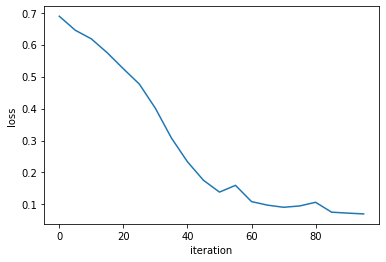

In [26]:
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(range(0,100,5), l)
plt.show()

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       423
           1       0.71      0.67      0.69       369

    accuracy                           0.72       792
   macro avg       0.72      0.71      0.71       792
weighted avg       0.72      0.72      0.72       792



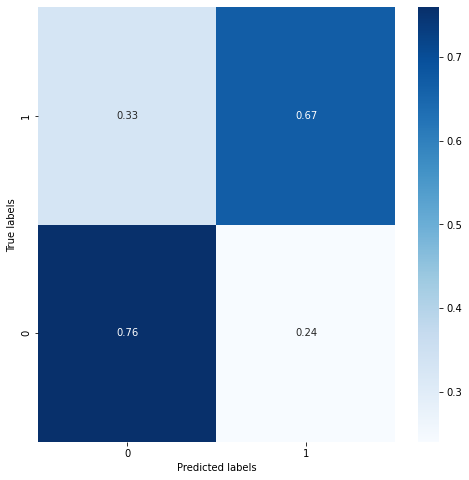

In [27]:
preds, probs, y_true = evaluation(model, val_loader, batch_size)
acc = accuracy_score(y_true, preds)
classification_report(y_true, preds)
 
 #peint calssification report
print(classification_report(y_true, preds))
 
 #build confusion matrix
con_mat = confusion_matrix(y_true, preds, labels=range(2))
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis] # normalization
con_mat_norm = np.around(con_mat_norm, decimals=2)
 #plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
plt.ylim(0, 2)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

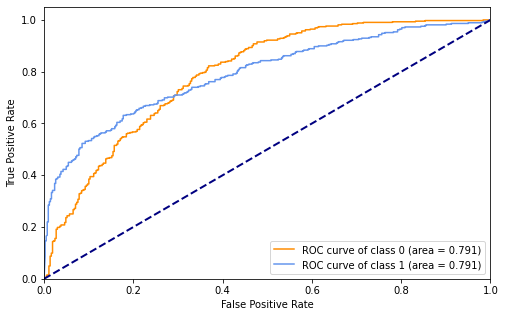

In [28]:
y_true = F.one_hot(torch.tensor(y_val, dtype=torch.long), num_classes = 2)
y_true = np.array(y_true).reshape(y_true.shape[0],-1)

plt.figure(figsize=(8, 5))
colors = ['darkorange', 'cornflowerblue']
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(2):
    fpr[i], tpr[i], threshold = roc_curve(y_true[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i], label='ROC curve of class %d (area = %.3f)' % (i,roc_auc[i]))
                
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

**Without augmentation**

In [12]:
x_train,x_val,y_train,y_val, test, w2vmodel, generated, feature_dim = prepocessing(False)
y_train = y_train.values.reshape(-1,1)
y_val = y_val.values.reshape(-1,1)

-------Deal with struct feature
-------Word2vec begin
-------Finish Transfer, Saving
Number of positive samples = 3271
Number of negative samples = 4342


In [18]:
test.shape

(3263, 22)

In [13]:
emb_weight = w2vmodel.wv.vectors
vocab_size, emb_size_doc = emb_weight.shape
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss().to(device)
model = BiLSTMPlus(2, vocab_size, emb_size_doc, emb_weight).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
batch_size = 256

In [14]:
train_dataset = CombineDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
val_dataset = CombineDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [15]:
count=0
l=[]
for e in range(100):
  loss = train(model, train_loader, optimizer, criterion, device, batch_size)
  if e==0:
    last=loss
  else:
    pre=loss
    if (last-pre)/last <=0.01:
      count+=1
    if count==5:
      l.append(loss)
      print("Final loss: %1.5f" % (loss))
      break
  if e % 5 == 0:
      l.append(loss)
      print("Epoch: %d, loss: %1.5f" % (e, loss)) 

Epoch: 0, loss: 0.74595
Epoch: 5, loss: 0.63915
Epoch: 10, loss: 0.61299
Epoch: 15, loss: 0.56740
Epoch: 20, loss: 0.47930
Epoch: 25, loss: 0.32642
Epoch: 30, loss: 0.23443
Epoch: 35, loss: 0.16205
Epoch: 40, loss: 0.11902
Epoch: 45, loss: 0.12803
Epoch: 50, loss: 0.10558
Epoch: 55, loss: 0.13011
Epoch: 60, loss: 0.06358
Epoch: 65, loss: 0.05625
Epoch: 70, loss: 0.05237
Epoch: 75, loss: 0.04930
Epoch: 80, loss: 0.04767
Epoch: 85, loss: 0.04356
Epoch: 90, loss: 0.04133
Epoch: 95, loss: 0.03934


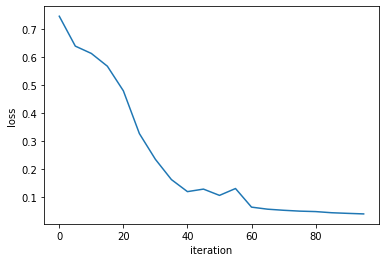

In [16]:
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(range(0,100,5), l)
plt.show()

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       438
           1       0.71      0.66      0.69       324

    accuracy                           0.74       762
   macro avg       0.74      0.73      0.74       762
weighted avg       0.74      0.74      0.74       762



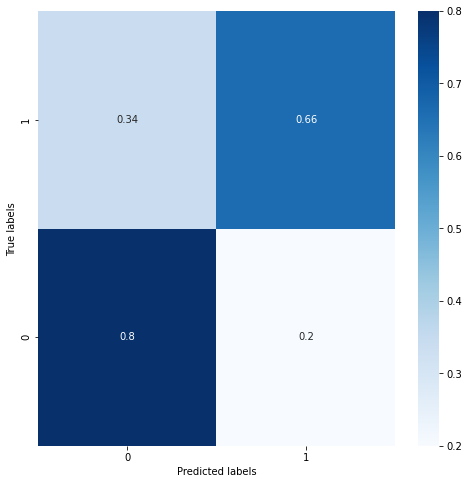

In [19]:
preds, probs, y_true = evaluation(model, val_loader, batch_size)
acc = accuracy_score(y_true, preds)
classification_report(y_true, preds)
 
 #peint calssification report
print(classification_report(y_true, preds))
 
 #build confusion matrix
con_mat = confusion_matrix(y_true, preds, labels=range(2))
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis] # normalization
con_mat_norm = np.around(con_mat_norm, decimals=2)
 #plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
plt.ylim(0, 2)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

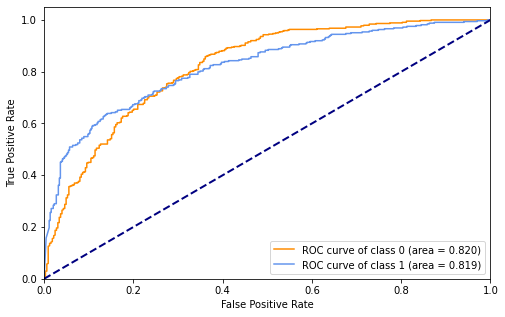

In [20]:
y_true = F.one_hot(torch.tensor(y_val, dtype=torch.long), num_classes = 2)
y_true = np.array(y_true).reshape(y_true.shape[0],-1)

plt.figure(figsize=(8, 5))
colors = ['darkorange', 'cornflowerblue']
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(2):
    fpr[i], tpr[i], threshold = roc_curve(y_true[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i], label='ROC curve of class %d (area = %.3f)' % (i,roc_auc[i]))
                
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()